In [1]:
stock = 'Google'

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv(f'{stock}.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3871,2020-01-06,1350.000000,1396.500000,1350.000000,1394.209961,1394.209961,1732300
3872,2020-01-07,1397.939941,1402.989990,1390.380005,1393.339966,1393.339966,1502700
3873,2020-01-08,1392.079956,1411.579956,1390.839966,1404.319946,1404.319946,1528000
3874,2020-01-09,1420.569946,1427.329956,1410.270020,1419.829956,1419.829956,1500900
3875,2020-01-10,1427.560059,1434.928955,1418.349976,1429.729980,1429.729980,1820700


In [3]:
data = pd.DataFrame()
data[f'{stock}'] = df['Adj Close'].copy()

In [4]:
data[f'D{stock}'] = data[f'{stock}'].diff()
data['Variance'] = (data[f'D{stock}']-data[f'D{stock}'].mean())**2

In [5]:
data.dropna(axis=0, inplace=True)
data.tail()

,Google,DGoogle,Variance
3871,1394.209961,33.549927,1101.832552
3872,1393.339966,-0.869995,1.503220
3873,1404.319946,10.979980,112.867595
3874,1419.829956,15.510010,229.642085
3875,1429.729980,9.900024,91.087176


In [6]:
# For each stock I estimated the RNN-LSTM model with different number of timesteps.
# For that reason I have to re-create the test data.
if stock == 'Google':
    timesteps = 6
elif stock == 'Amazon':
    timesteps = 2
else:
    timesteps = 20

In [7]:
data_test = pd.DataFrame()
data_test['Variance'] = data['Variance'][-timesteps-3:].copy()

## Creating Test Data

In [8]:
import numpy as np

x_test = []
y_test = []

for i in range(timesteps, data_test.shape[0]):
    x_test.append(data_test['Variance'].iloc[i-timesteps:i].values.tolist())
    y_test.append((data_test['Variance'].iloc[i]))

x_test, y_test = np.array(x_test), np.array(y_test)

x_test.shape, y_test.shape

((3, 6), (3,))

In [9]:
from sklearn.preprocessing import FunctionTransformer
scaler = FunctionTransformer(np.log1p, validate=True)
x_test = scaler.fit_transform(x_test)
x_test = x_test[..., np.newaxis]
x_test.shape

(3, 6, 1)

## Loading Tensorflow Model

In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model = load_model(f'models\{stock}')

In [11]:
y_pred = model.predict(x_test)

In [12]:
from sklearn.metrics import mean_absolute_error
mae = round(mean_absolute_error(y_test, y_pred), 3)
print('The MAE for the RNN-LSTM model is: ' + str(mae))

The MAE for the RNN-LSTM model is: 7.921


## Loading the results from the GARCH models

In [13]:
df = pd.read_excel(f'{stock} Forecasts.xlsx', index_col=0)
df['RNN-LSTM'] = y_pred
df

,Google,DGoogle,Variance,GARCH,EGARCH,FIGARCH,RNN-LSTM
Date,,,,,,,
2020-01-08,1404.319946,10.979980,112.867595,357.645955,177.663147,315.114559,105.314102
2020-01-09,1419.829956,15.510010,229.642085,491.215491,226.273557,264.276024,214.683548
2020-01-10,1429.729980,9.900024,91.087176,357.633741,233.373077,243.135037,92.337570


## Visualization 

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

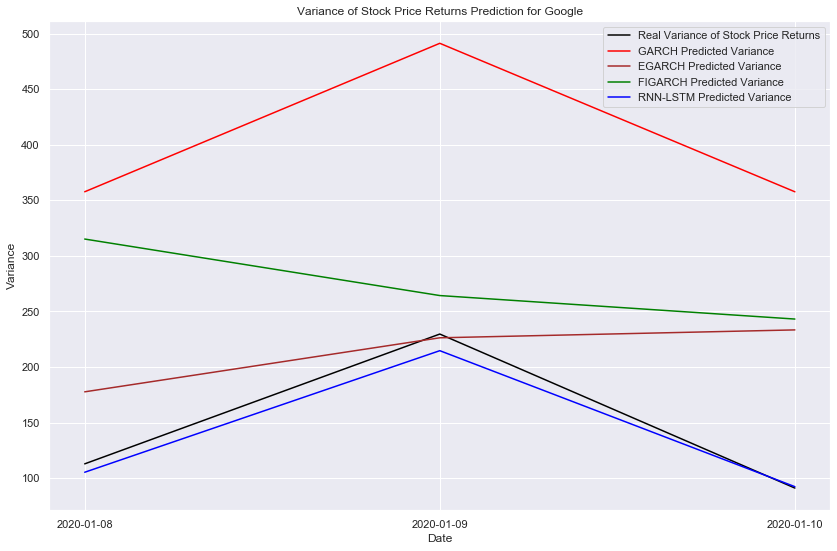

In [15]:
plt.figure(figsize=(14,9))
plt.plot(df['Variance'], color = 'black', label = 'Real Variance of Stock Price Returns')
plt.plot(df['GARCH'], color = 'red', label = 'GARCH Predicted Variance')
plt.plot(df['EGARCH'], color = 'brown', label = 'EGARCH Predicted Variance')
plt.plot(df['FIGARCH'], color = 'green', label = 'FIGARCH Predicted Variance')
plt.plot(df['RNN-LSTM'], color = 'blue', label = 'RNN-LSTM Predicted Variance')
plt.title(f'Variance of Stock Price Returns Prediction for {stock}')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.legend()
plt.show()

In [16]:
df.to_excel(f"{stock} Forecasts.xlsx")